# Implementação de Rede Neural Convolucional (CNN) com PyTorch

Este notebook implementa uma arquitetura CNN personalizada do zero com o uso de bibliotecas, PyTorch, além de experimentá-los com modelos pré-treinados, utilizando transfer-learning.

In [20]:
# Importar as Bibliotecas
import cv2
import matplotlib.pyplot as plt
import numpy as np
import optuna
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import torch
import torch.autograd as Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Suprimir os Warnings
import warnings
warnings.filterwarnings('ignore')

## Arquitetura da CNN personalizada
Atendendo os mínimos requisitos para que o modelo seja uma CNN. Os ajustes foram feitos para a tarefa do dataset MNIST que será usado.

In [21]:
# Definir a arquitetura da rede neural personalizada
class CNNcustomMin(nn.Module):
    def __init__(self):
        super(CNNcustomMin, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # Camada da convolução 1
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # Camada da convolução 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)                                # Camada do pooling
        self.fc1 = nn.Linear(64*7*7, 128)                                                           # Camada totalmente conectada 1
        self.fc2 = nn.Linear(128, 10)                                                               # Camada totalmente conectada 2                                                          

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))                                                        # Aplicar a convolução 1 e a função de ativação ReLU
        x = self.pool(F.relu(self.conv2(x)))                                                        # Aplicar a convolução 2 e a função de ativação ReLU
        x = x.view(-1, 64*7*7)                                                                      # Redimensionar o tensor
        x = F.relu(self.fc1(x))                                                                     # Aplicar a camada totalmente conectada 1 e a função de ativação ReLU
        x = self.fc2(x)                                                                             # Aplicar a camada totalmente conectada 2
        return x

Funções genéricas de Treinamento e Avaliação:

In [22]:
# Implementar função Treinamento
def trainer(model, trains_manager, descrition, refiner, n_epochs=10, losses_record=None):
    trainer_timer_Start = time.time()                       # Iniciar o temporizador
    model.train()                                           # Colocar o modelo em modo de treinamento
    for epoch in range(n_epochs):
        current_loss = 0.0                                  # Iniciar a perda
        for inputs, labels in trains_manager:
            refiner.zero_grad()                             # Zerar os gradientes
            outputs = model(inputs)                         # Realizar a predição
            loss = descrition(outputs, labels)              # Calcular a perda
            loss.backward()                                 # Realizar a retropropagação
            refiner.step()                                  # Atualizar os pesos
            current_loss += loss.item()                     # Atualizar a perda
        epoch_loss = current_loss / len(trains_manager)     # Calcular a perda da época
        losses_record.append(epoch_loss)                    # Adicionar a perda à lista
        print('Epoch: %d, Loss: %.3f' % (epoch + 1, current_loss / len(trains_manager)))
    trainer_timer_End = time.time()                         # Finalizar o temporizador
    timer = trainer_timer_End - trainer_timer_Start         # Calcular o tempo de treinamento
    print('Training Time: %.2f seconds' % timer)
    print('Trained')
    return timer

# Implementar função de Avaliação
def evaluetor(model, tests_manager):
    model.eval()                                            # Colocar o modelo em modo de avaliação
    correct = 0                                             # Inicializar a quantidade de predições corretas
    total = 0                                               # Inicializar a quantidade total de predições
    labels_list = []                                        # Inicializar a lista de rótulos
    predicteds_list = []                                    # Inicializar a lista de predições
    with torch.no_grad():
        for inputs, labels in tests_manager:
            outputs = model(inputs)                         # Realizar a predição
            _, predicted = torch.max(outputs.data, 1)       # Obter a predição
            total += labels.size(0)                         # Atualizar a quantidade total de predições
            correct += (predicted == labels).sum().item()   # Atualizar a quantidade de predições corretas
            labels_list += labels.tolist()                  # Atualizar a lista de rótulos
            predicteds_list += predicted.tolist()           # Atualizar a lista de predições
    accuracy = 100 * correct / total                        # Calcular a acurácia
    print('Accuracy: %.2f %%' % accuracy)
    return labels_list, predicteds_list, accuracy

Funções de visualização:

In [23]:
# Matriz de Confusão
def plot_CM(labels, predicteds):
    cm = confusion_matrix(labels, predicteds)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Curvas de perda
def plot_L(losses_record):
    plt.plot(losses_record, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Carregar DataSet
Organizar o dataset MNIST para usar para treinar a testar os modelos.

In [24]:
# Carregar o dataset MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)

# Dividir o dataset em conjuntos de treinamento e validação (80% treinamento, 20% validação)
train_size = int(0.8 * len(dataset))
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [train_size, eval_size])

# Definir os DataLoader
trains_manager = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
tests_manager = torch.utils.data.DataLoader(eval_dataset, batch_size=64, shuffle=False)

## Treino e Avaliação
Iniciar e ajustar os parâmetros finais para executar.

Epoch: 1, Loss: 0.175
Epoch: 2, Loss: 0.050
Epoch: 3, Loss: 0.034
Epoch: 4, Loss: 0.025
Epoch: 5, Loss: 0.018
Epoch: 6, Loss: 0.014
Epoch: 7, Loss: 0.013
Epoch: 8, Loss: 0.009
Epoch: 9, Loss: 0.010
Epoch: 10, Loss: 0.008
Training Time: 269.07 seconds
Trained


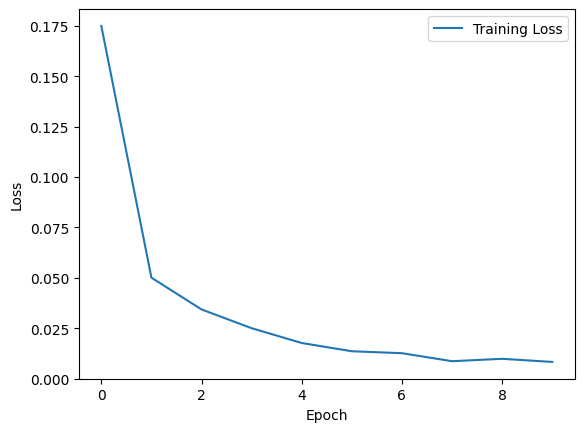

Accuracy: 98.84 %


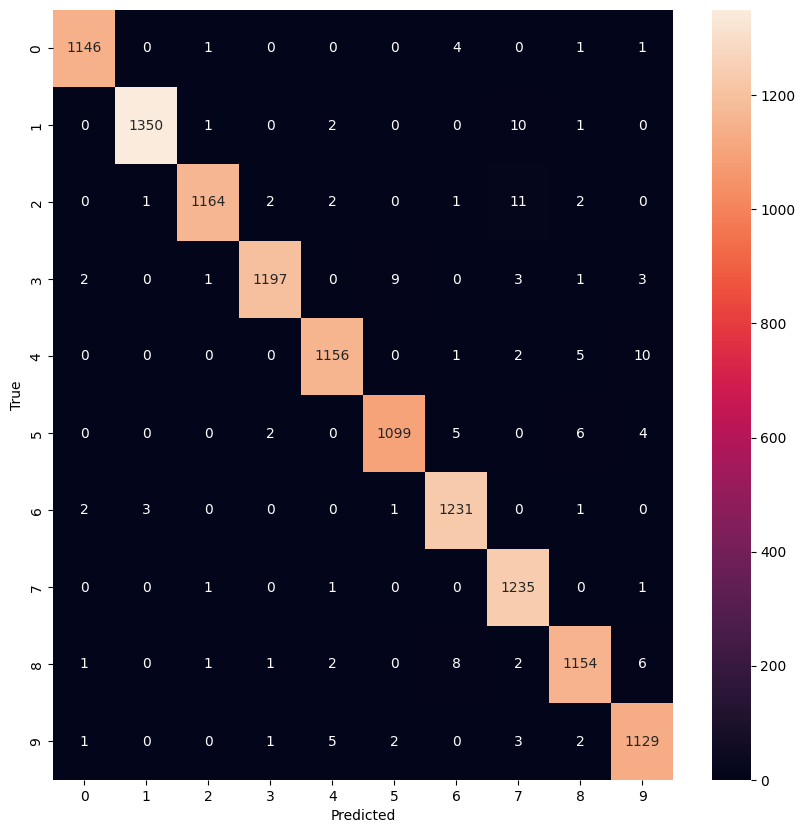

In [25]:
# Carregar o modelo personalizado
cm_model = CNNcustomMin()
description = nn.CrossEntropyLoss()                     # Função de perda
refiner = optim.Adam(cm_model.parameters(), lr=0.001)   # Otimizador

# Treinar o modelo personalizado e registrar as perdas
cm_train_losses = []                                    # Iniciar a lista de perdas
cm_train_timer = trainer(cm_model, trains_manager, description, refiner, n_epochs=10, losses_record=cm_train_losses)

# Plotar as curvas de perda
plot_L(cm_train_losses)

# Avaliar o modelo personalizado no conjunto de validação
cm_labels, cm_predicteds, cm_accuracy = evaluetor(cm_model, tests_manager)

# Plotar a matriz de confusão
plot_CM(cm_labels, cm_predicteds)

# Outras métricas
cm_precision = precision_score(cm_labels, cm_predicteds, average='weighted')
cm_recall = recall_score(cm_labels, cm_predicteds, average='weighted')
cm_f1 = f1_score(cm_labels, cm_predicteds, average='weighted')

Epoch: 1, Loss: 0.834
Epoch: 2, Loss: 0.607
Epoch: 3, Loss: 0.581
Epoch: 4, Loss: 0.562
Epoch: 5, Loss: 0.555
Epoch: 6, Loss: 0.551
Epoch: 7, Loss: 0.543
Epoch: 8, Loss: 0.548
Epoch: 9, Loss: 0.543
Epoch: 10, Loss: 0.540
Training Time: 1006.67 seconds
Trained


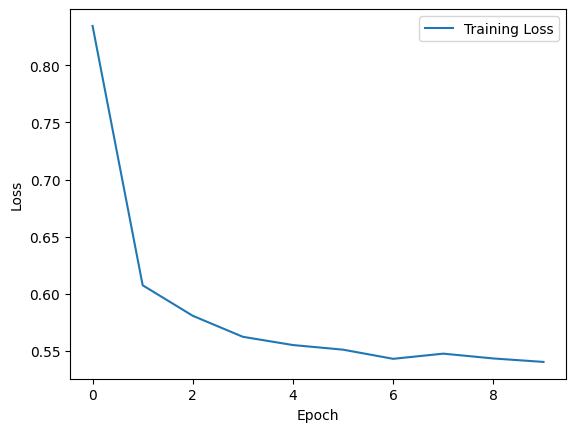

Accuracy: 82.49 %


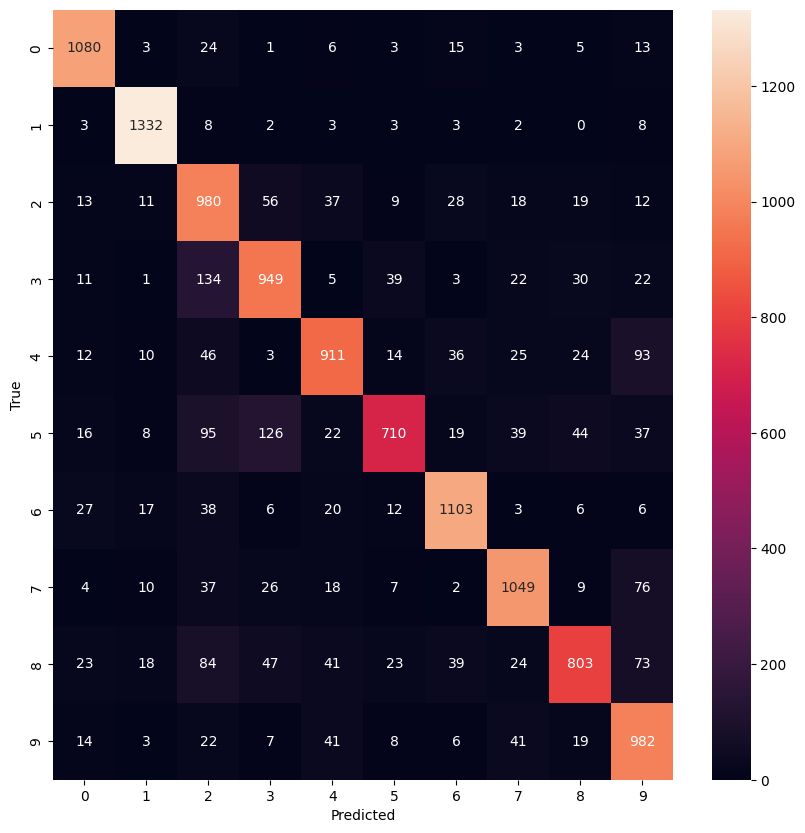

In [26]:
# Carregar o modelo pré-treinado ResNet18
p_model = models.resnet18(pretrained=True)

# Ajustar a primeira camada convolucional para receber 1 canal
p_model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=3, bias=False)

# Ajustar a última camada totalmente conectada para 10 classes
p_model.fc = nn.Linear(p_model.fc.in_features, 10)

# Congelar as camadas convolucionais
for parameter in p_model.parameters():
    parameter.requires_grad = False

# Treinar apenas a última camada totalmente conectada
for parameter in p_model.fc.parameters():
    parameter.requires_grad = True

# Iniciar critério e otimizador
description = nn.CrossEntropyLoss()                     # Função de perda
refiner = optim.Adam(p_model.fc.parameters(), lr=0.001) # Otimizador

# Treinar o modelo pré-treinado e registrar as perdas
p_train_losses = []                                     # Iniciar a lista de perdas
p_train_timer = trainer(p_model, trains_manager, description, refiner, n_epochs=10, losses_record=p_train_losses)

# Plotar as curvas de perda
plot_L(p_train_losses)

# Avaliar o modelo pré-treinado no conjunto de validação
p_labels, p_predicteds, p_accuracy = evaluetor(p_model, tests_manager)

# Plotar a matriz de confusão
plot_CM(p_labels, p_predicteds)

# Outras métricas
p_precision = precision_score(p_labels, p_predicteds, average='weighted')
p_recall = recall_score(p_labels, p_predicteds, average='weighted')
p_f1 = f1_score(p_labels, p_predicteds, average='weighted')

## Comparação do desempenho
Com o auxílio das métricas geradas, podemos ter uma conclusão mais acertiva sobre o desempenho dos modelos.

In [27]:
# Comparar os modelos
print('Pre-trained model:')
print('Time: %.2f seconds' % p_train_timer)
print('Accuracy: %.2f %%' % p_accuracy)
print('Precision: %.2f' % p_precision)
print('Recall: %.2f' % p_recall)
print('F1: %.2f' % p_f1)

print('\nCustom model:')
print('Time: %.2f seconds' % cm_train_timer)
print('Accuracy: %.2f %%' % cm_accuracy)
print('Precision: %.2f' % cm_precision)
print('Recall: %.2f' % cm_recall)
print('F1: %.2f' % cm_f1)

Pre-trained model:
Time: 1006.67 seconds
Accuracy: 82.49 %
Precision: 0.83
Recall: 0.82
F1: 0.82

Custom model:
Time: 269.07 seconds
Accuracy: 98.84 %
Precision: 0.99
Recall: 0.99
F1: 0.99


## Conclusão
O tamanho pequeno no modelo personalizado faz com que ele seja rápido e possui uma acurácia boa; ele se sai melhor do que o pré-treinado em todos os quesitos, provavelmenta, pelo fato de que o modelo ResNet-18 possui mais parâmetros do que o personalizado e que é um modelo para situações mais complexas. A CNN personalizada é mais simples e rápida de treinar, sendo adequada para tarefas específicas e datasets menores como o MNIST. Já a ResNet18, com sua arquitetura mais complexa e pré-treinamento, deve possuir uma melhor capacidade de generalização.


### CNN Regularizada
Ajustaremos a CNN para que ela possua um DropOut e então realizar um tuning de hiperparâmetros.

In [28]:
class CNNcustomRegularized(nn.Module):
    def __init__(self):
        super(CNNcustomRegularized, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # Camada da convolução 1
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # Camada da convolução 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)                                # Camada do pooling
        self.fc1 = nn.Linear(64*7*7, 128)                                                           # Camada totalmente conectada 1
        self.fc2 = nn.Linear(128, 10)                                                               # Camada totalmente conectada 2
        self.dropout = nn.Dropout(0.5)                                                              # Camada de regularização

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))                                                        # Aplicar a convolução 1 e a função de ativação ReLU
        x = self.pool(F.relu(self.conv2(x)))                                                        # Aplicar a convolução 2 e a função de ativação ReLU
        x = x.view(-1, 64*7*7)                                                                      # Redimensionar o tensor
        x = F.relu(self.fc1(x))                                                                     # Aplicar a camada totalmente conectada 1 e a função de ativação ReLU
        x = self.dropout(x)                                                                         # Aplicar a camada de regularização
        x = self.fc2(x)                                                                             # Aplicar a camada totalmente conectada 2
        return x

Treinar e Avaliar o modelo:

Epoch: 1, Loss: 0.296
Epoch: 2, Loss: 0.100
Epoch: 3, Loss: 0.077
Epoch: 4, Loss: 0.063
Epoch: 5, Loss: 0.054
Epoch: 6, Loss: 0.044
Epoch: 7, Loss: 0.041
Epoch: 8, Loss: 0.034
Epoch: 9, Loss: 0.032
Epoch: 10, Loss: 0.029
Training Time: 292.46 seconds
Trained


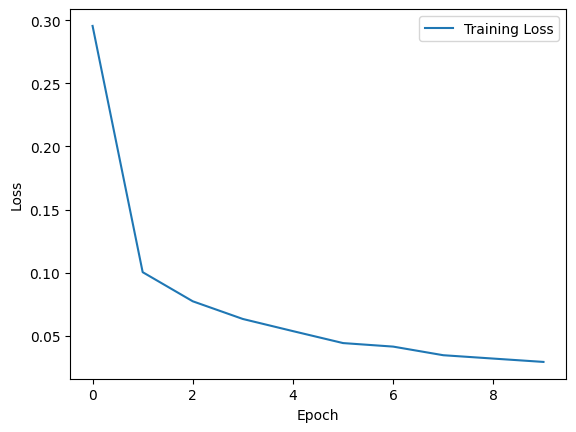

Accuracy: 99.06 %


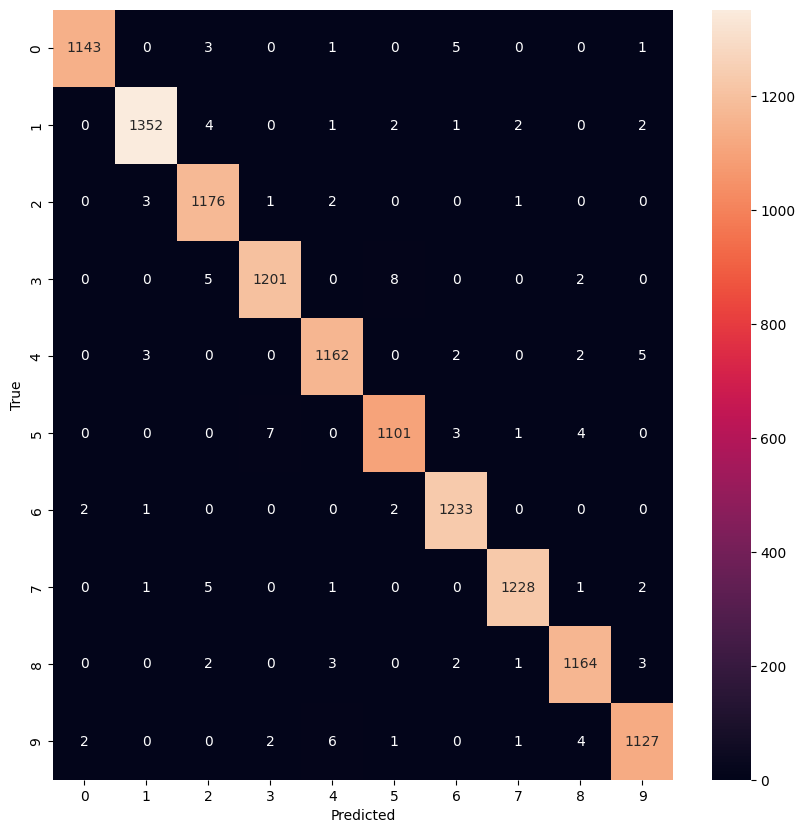

In [29]:
# Iniciar o modelo personalizado regularizado
cr_model = CNNcustomRegularized()
description = nn.CrossEntropyLoss()                     # Função de perda
refiner = optim.Adam(cr_model.parameters(), lr=0.001)   # Otimizador

# Treinar o modelo personalizado regularizado e registrar as perdas
cr_train_losses = []                                    # Iniciar a lista de perdas
cr_train_timer = trainer(cr_model, trains_manager, description, refiner, n_epochs=10, losses_record=cr_train_losses)

# Plotar as curvas de perda
plot_L(cr_train_losses)

# Avaliar o modelo personalizado regularizado no conjunto de validação
cr_labels, cr_predicteds, cr_accuracy = evaluetor(cr_model, tests_manager)

# Plotar a matriz de confusão
plot_CM(cr_labels, cr_predicteds)

# Outras métricas
cr_precision = precision_score(cr_labels, cr_predicteds, average='weighted')
cr_recall = recall_score(cr_labels, cr_predicteds, average='weighted')
cr_f1 = f1_score(cr_labels, cr_predicteds, average='weighted')

### ###EXTRA###
Pré-treinada com Regularizador (dropout):

Epoch: 1, Loss: 1.157
Epoch: 2, Loss: 0.986
Epoch: 3, Loss: 0.990
Epoch: 4, Loss: 0.994
Epoch: 5, Loss: 0.984
Epoch: 6, Loss: 0.982
Epoch: 7, Loss: 0.983
Epoch: 8, Loss: 0.990
Epoch: 9, Loss: 0.985
Epoch: 10, Loss: 0.986
Training Time: 988.47 seconds
Trained


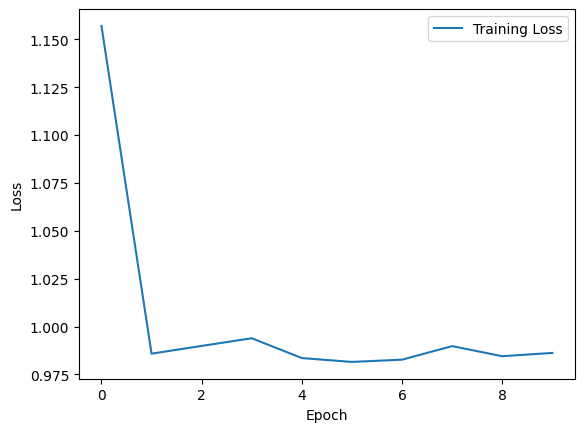

Accuracy: 79.05 %


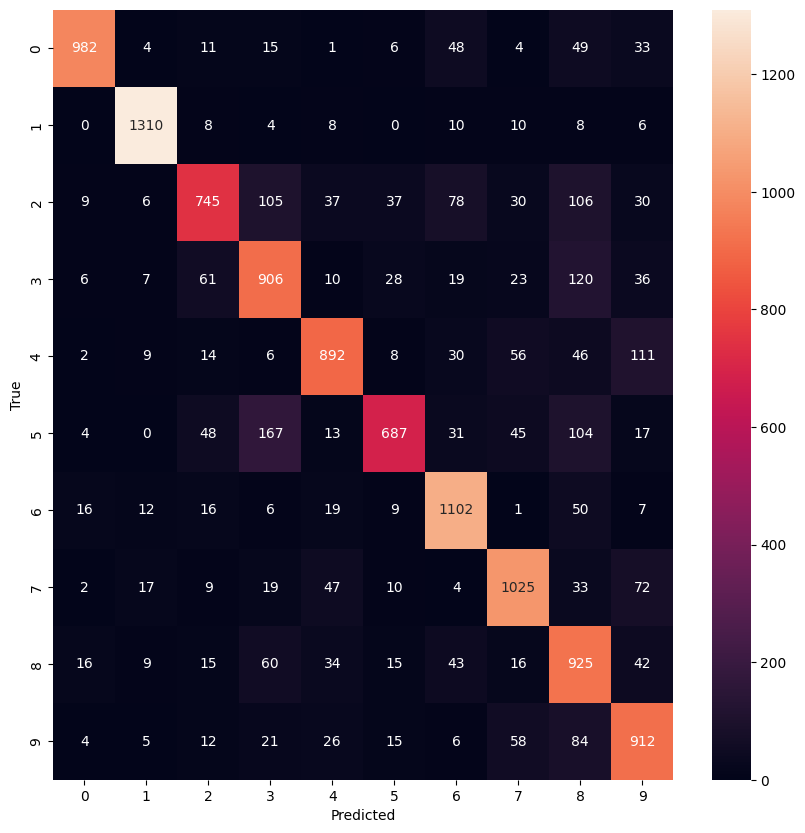

In [30]:
# Carregar o modelo pré-treinado ResNet18
pr_model = models.resnet18(pretrained=True)

# Ajustar a primeira camada convolucional para receber 1 canal
pr_model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=3, bias=False)

# Ajustar a última camada totalmente conectada para 10 classes
pr_model.fc = nn.Sequential(
    nn.Dropout(0.5),                                        # Adicionar Dropout
    nn.Linear(pr_model.fc.in_features, 10)
)

# Congelar as camadas convolucionais
for parameter in pr_model.parameters():
    parameter.requires_grad = False

# Treinar apenas a última camada totalmente conectada
for parameter in pr_model.fc.parameters():
    parameter.requires_grad = True

# Iniciar critério e otimizador
description = nn.CrossEntropyLoss()                         # Função de perda
refiner = optim.Adam(pr_model.fc.parameters(), lr=0.001)    # Otimizador

# Treinar o modelo pré-treinado e registrar as perdas
p_train_losses = []                                         # Iniciar a lista de perdas
p_train_timer = trainer(pr_model, trains_manager, description, refiner, n_epochs=10, losses_record=p_train_losses)

# Plotar as curvas de perda
plot_L(p_train_losses)

# Avaliar o modelo pré-treinado no conjunto de validação
p_labels, p_predicteds, p_accuracy = evaluetor(pr_model, tests_manager)

# Plotar a matriz de confusão
plot_CM(p_labels, p_predicteds)

# Outras métricas
p_precision = precision_score(p_labels, p_predicteds, average='weighted')
p_recall = recall_score(p_labels, p_predicteds, average='weighted')
p_f1 = f1_score(p_labels, p_predicteds, average='weighted')

Verificar os ajustes nos Hiperparâmetros:

In [31]:
# Automatizar a busca de hiperparâmetros
def tuning(trial):
    # Definir os hiperparâmetros a serem otimizados
    dropout = trial.suggest_uniform('dropout', 0.1, 0.9)                    # Taxa de dropout
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)   # Taxa de aprendizado
    ## Existem outros hipermarâmetros que podem ser otimizados, mas estamos apenas realizando uma pequena demonstração

    # Escolher o modelo para otimização
    cr_model = CNNcustomRegularized()
    description = nn.CrossEntropyLoss()                                     # Função de perda
    refiner = optim.Adam(cr_model.parameters(), lr=learning_rate)           # Otimizador

    # Treinar o modelo e registrar as perdas
    cr_train_losses = []                                                    # Iniciar a lista de perdas
    cr_train_timer = trainer(cr_model, trains_manager, description, refiner, n_epochs=10, losses_record=cr_train_losses)

    # Avaliar o modelo personalizado regularizado no conjunto de validação
    cr_labels, cr_predicteds, cr_accuracy = evaluetor(cr_model, tests_manager)

    return cr_accuracy

# Otimizar os hiperparâmetros
study = optuna.create_study(direction='maximize')                           # Definir a direção da otimização
study.optimize(tuning, n_trials=5)                                          # Definir o número de tentativas

# Obter os melhores hiperparâmetros
best_params = study.best_params                                             # Obter os melhores hiperparâmetros
best_accuracy = study.best_value                                            # Obter a melhor acurácia
print('Best trial:')
trial = study.best_trial                                                    # Obter o melhor teste
print('Accuracy: %.2f %%' % best_accuracy)
print('   Params: ')
for key, value in trial.params.items():
    print('        %s: %s' % (key, value))

[I 2025-03-04 22:02:11,353] A new study created in memory with name: no-name-d0702324-cf7c-4e78-a989-bc1b91d18311


Epoch: 1, Loss: 0.336
Epoch: 2, Loss: 0.113
Epoch: 3, Loss: 0.088
Epoch: 4, Loss: 0.070
Epoch: 5, Loss: 0.060
Epoch: 6, Loss: 0.051
Epoch: 7, Loss: 0.043
Epoch: 8, Loss: 0.039
Epoch: 9, Loss: 0.035
Epoch: 10, Loss: 0.031
Training Time: 229.31 seconds
Trained


[I 2025-03-04 22:06:03,397] Trial 0 finished with value: 98.98333333333333 and parameters: {'dropout': 0.21852217901834514, 'learning_rate': 0.000760526694264643}. Best is trial 0 with value: 98.98333333333333.


Accuracy: 98.98 %
Epoch: 1, Loss: 1.460
Epoch: 2, Loss: 0.580
Epoch: 3, Loss: 0.403
Epoch: 4, Loss: 0.324
Epoch: 5, Loss: 0.270
Epoch: 6, Loss: 0.230
Epoch: 7, Loss: 0.203
Epoch: 8, Loss: 0.183
Epoch: 9, Loss: 0.164
Epoch: 10, Loss: 0.152
Training Time: 215.64 seconds
Trained


[I 2025-03-04 22:09:41,668] Trial 1 finished with value: 97.09166666666667 and parameters: {'dropout': 0.7775813707324656, 'learning_rate': 2.6935615163723938e-05}. Best is trial 0 with value: 98.98333333333333.


Accuracy: 97.09 %
Epoch: 1, Loss: 0.273
Epoch: 2, Loss: 0.101
Epoch: 3, Loss: 0.075
Epoch: 4, Loss: 0.063
Epoch: 5, Loss: 0.053
Epoch: 6, Loss: 0.045
Epoch: 7, Loss: 0.039
Epoch: 8, Loss: 0.036
Epoch: 9, Loss: 0.028
Epoch: 10, Loss: 0.028
Training Time: 226.72 seconds
Trained


[I 2025-03-04 22:13:31,059] Trial 2 finished with value: 98.91666666666667 and parameters: {'dropout': 0.5094374189141226, 'learning_rate': 0.0011535233214363338}. Best is trial 0 with value: 98.98333333333333.


Accuracy: 98.92 %
Epoch: 1, Loss: 1.878
Epoch: 2, Loss: 0.952
Epoch: 3, Loss: 0.628
Epoch: 4, Loss: 0.493
Epoch: 5, Loss: 0.409
Epoch: 6, Loss: 0.358
Epoch: 7, Loss: 0.316
Epoch: 8, Loss: 0.288
Epoch: 9, Loss: 0.260
Epoch: 10, Loss: 0.238
Training Time: 239.39 seconds
Trained


[I 2025-03-04 22:17:33,508] Trial 3 finished with value: 95.21666666666667 and parameters: {'dropout': 0.6203046660942052, 'learning_rate': 1.0964803125283946e-05}. Best is trial 0 with value: 98.98333333333333.


Accuracy: 95.22 %
Epoch: 1, Loss: 0.246
Epoch: 2, Loss: 0.091
Epoch: 3, Loss: 0.068
Epoch: 4, Loss: 0.056
Epoch: 5, Loss: 0.048
Epoch: 6, Loss: 0.041
Epoch: 7, Loss: 0.038
Epoch: 8, Loss: 0.035
Epoch: 9, Loss: 0.030
Epoch: 10, Loss: 0.028
Training Time: 248.35 seconds
Trained


[I 2025-03-04 22:21:44,718] Trial 4 finished with value: 99.00833333333334 and parameters: {'dropout': 0.7740159632006296, 'learning_rate': 0.0014954203668915396}. Best is trial 4 with value: 99.00833333333334.


Accuracy: 99.01 %
Best trial:
Accuracy: 99.01 %
   Params: 
        dropout: 0.7740159632006296
        learning_rate: 0.0014954203668915396


## Conclusão
A regularização deixa mais lento, porém mais robusto, o modelo; devido ao tamanho do modelo e a simplicidade do dataset, a melhoria não é muito elevada e a otimização de hiperparâmetros não foi levada muito afundo, apenas exemplificada (os hiperparâmetros iniciais se mostraram os excelentes). 

## Visualização do mapa de características
Obter uma melhor compreensão de como o processo de treinamento está progredindo.

Mapas de Características da CNN Regularizada


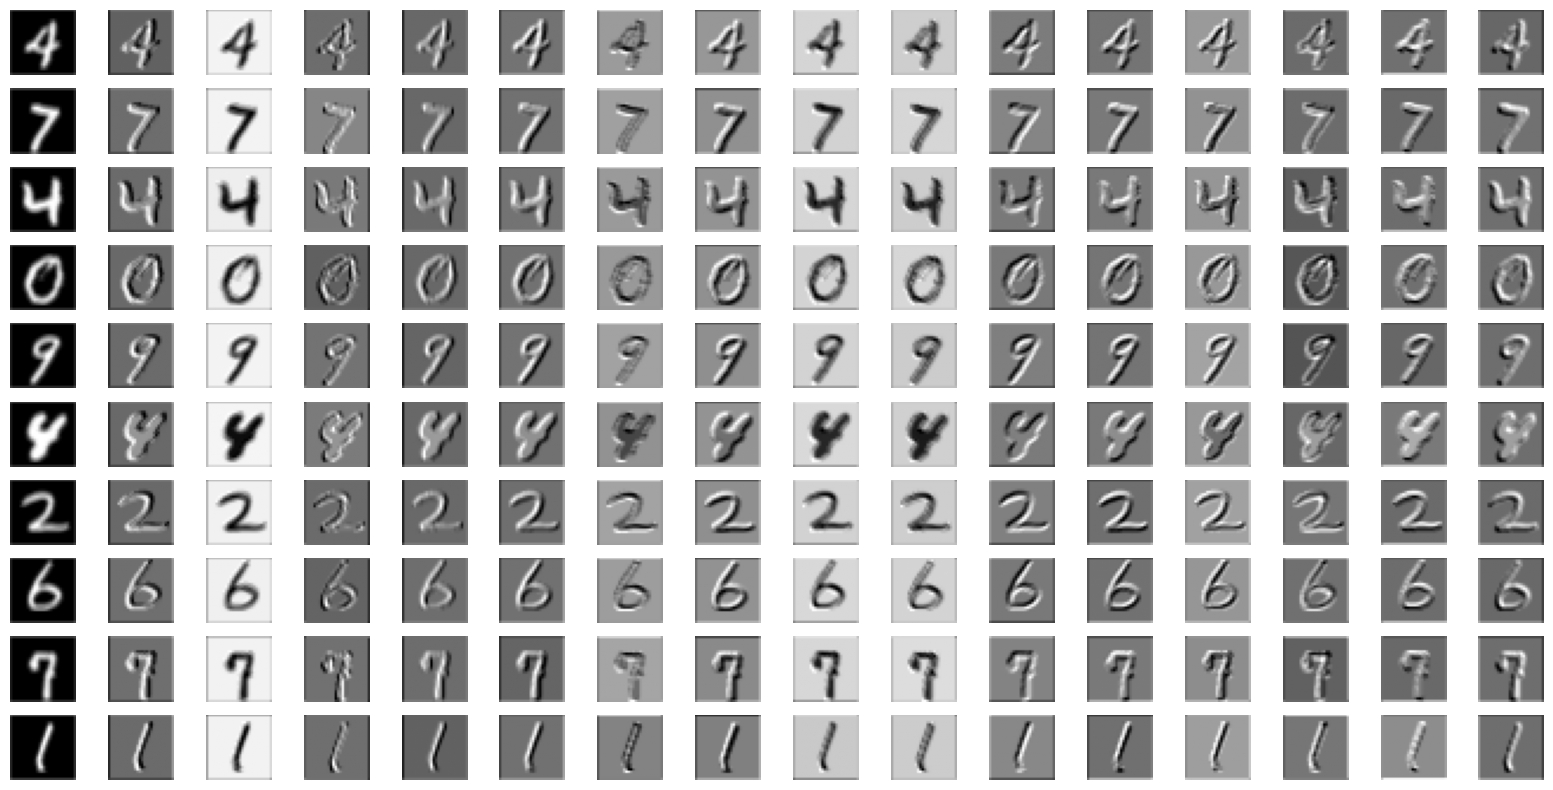

Mapas de Características da CNN Personalizada


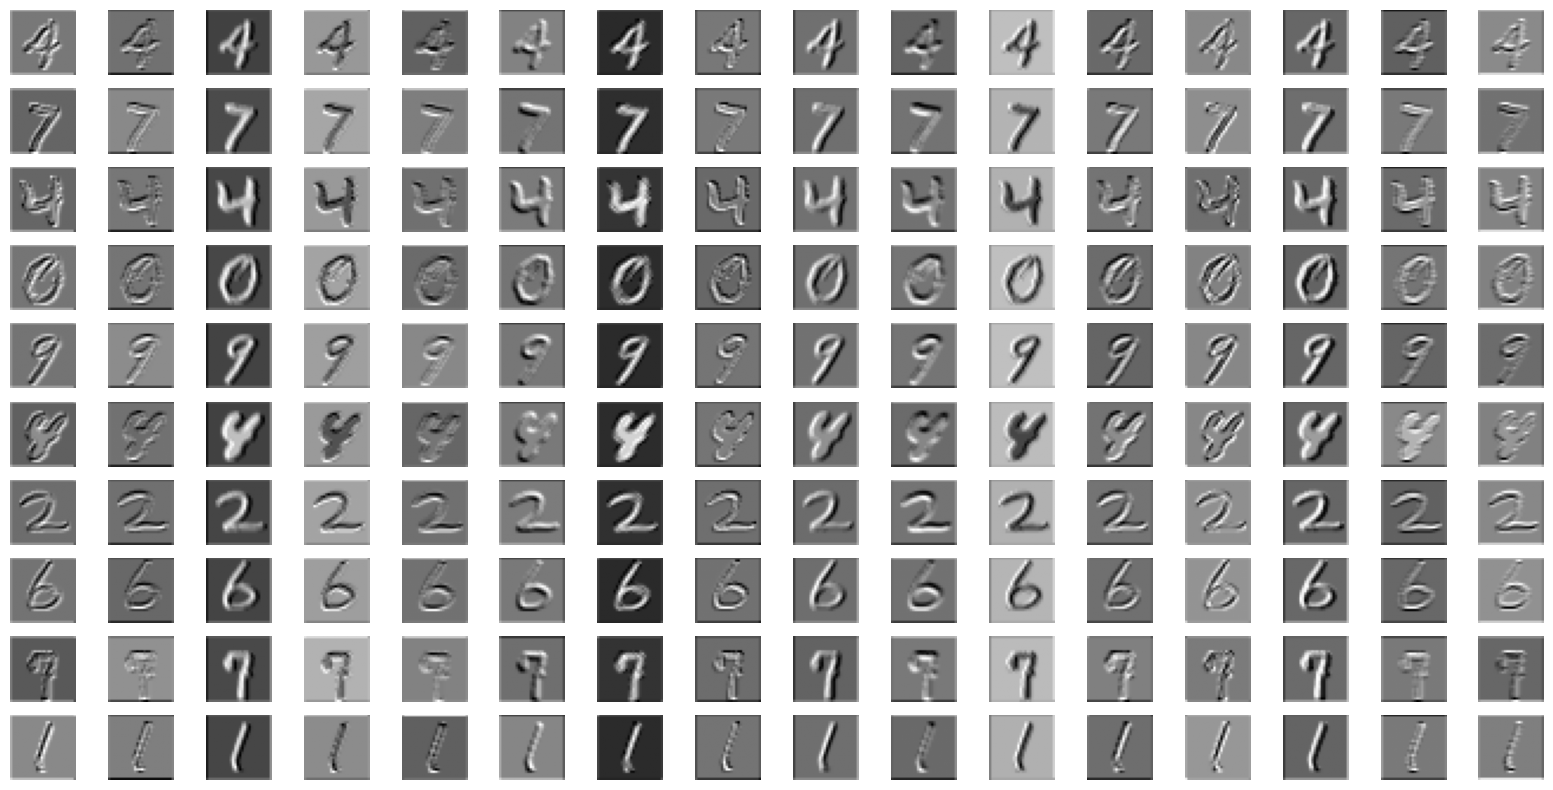

Mapas de Características da CNN Pré-treinada


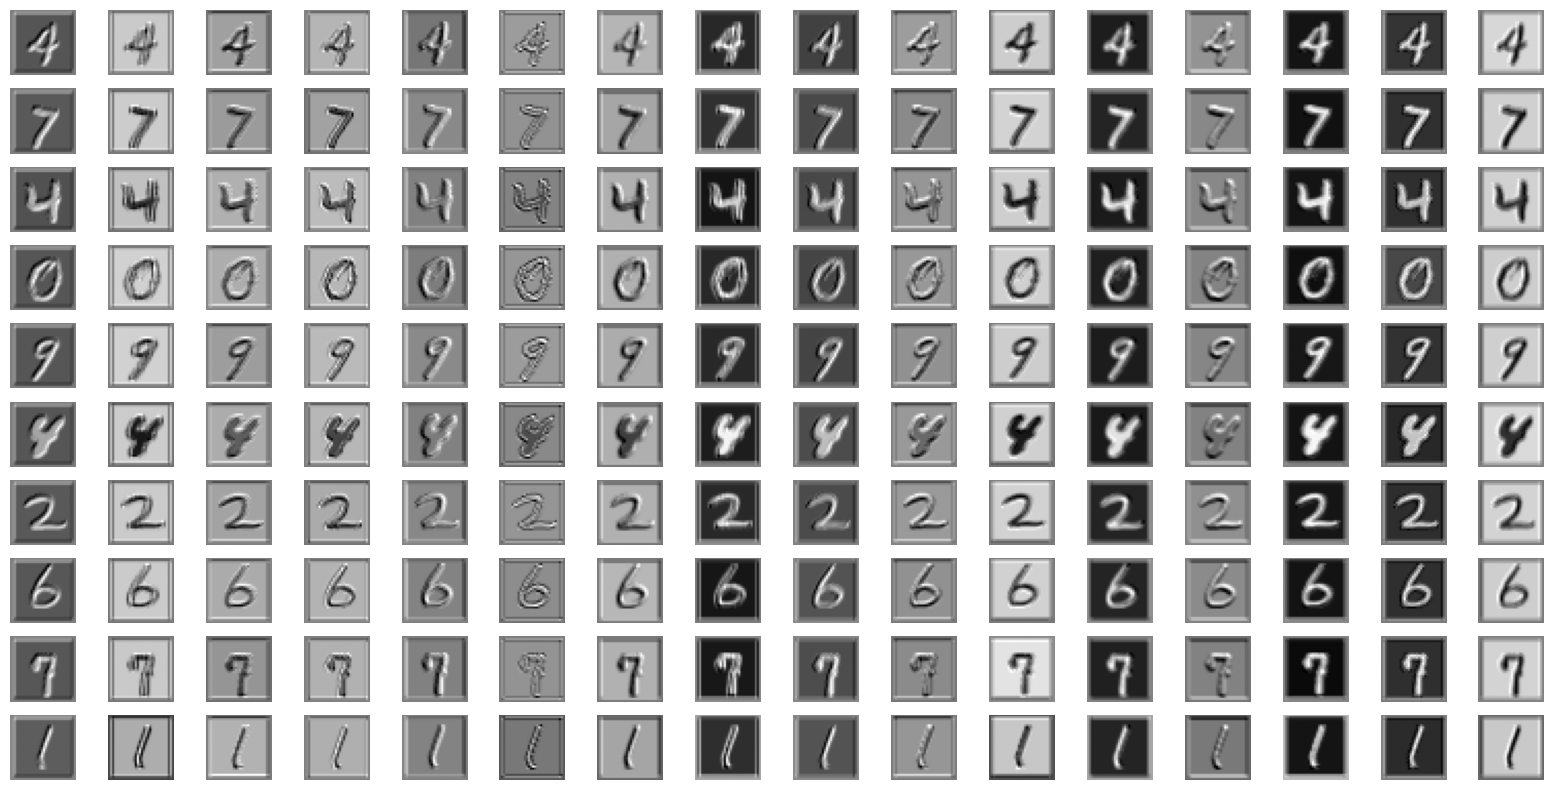

Mapas de Características da CNN Pré-treinada Regularizada


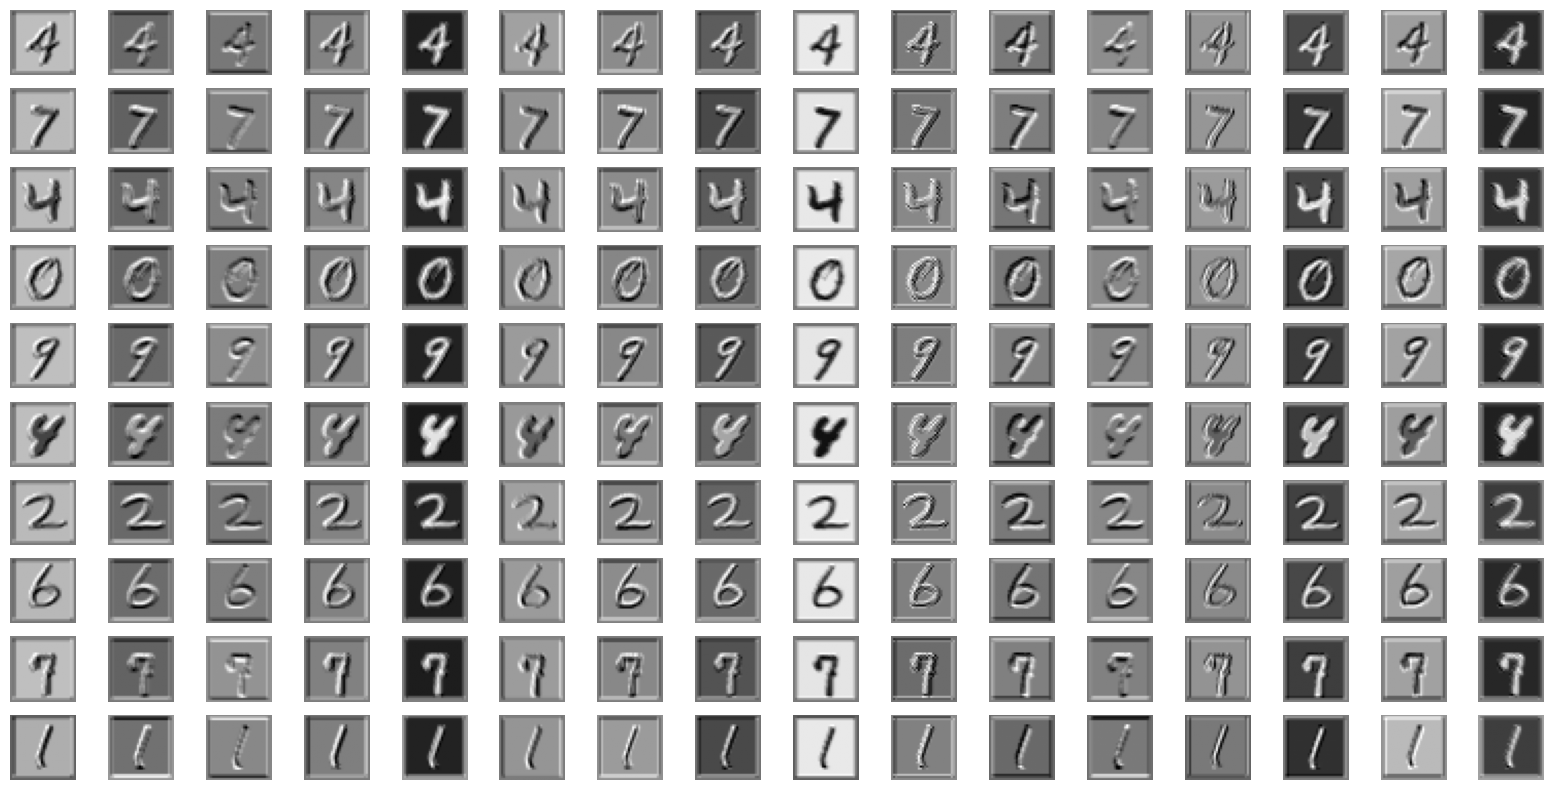

In [32]:
# Carregar as imagens do conjunto de validação
def feature_maps(model, data_loader):
    model.eval()                                            # Colocar o modelo em modo de avaliação
    features = []                                           # Iniciar a lista de características
    labels = []                                             # Iniciar a lista de rótulos
    with torch.no_grad():
        for inputs, labels_ in data_loader:
            outputs = model.conv1(inputs)                   # Obter as características da primeira camada convolucional
            fig, ax = plt.subplots(10, 16, figsize=(20, 10))
            for i in range(10):
                for j in range(16):
                    ax[i, j].imshow(outputs[i, j].numpy(), cmap='gray')
                    ax[i, j].axis('off')
            plt.show()
            break

# Visualizar os mapas da CNN Regularizada
print('Mapas de Características da CNN Regularizada')
feature_maps(cr_model, tests_manager)

# Visualizar os mapas da CNN
print('Mapas de Características da CNN Personalizada')
feature_maps(cm_model, tests_manager)

# Visualizar os mapas da CNN Pré-treinada
print('Mapas de Características da CNN Pré-treinada')
feature_maps(p_model, tests_manager)

# Visualizar os mapas da CNN Pré-treinada Regularizada
print('Mapas de Características da CNN Pré-treinada Regularizada')
feature_maps(pr_model, tests_manager)


In [33]:
# Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx=None):
        self.model.eval()
        for param in self.target_layer.parameters():
            param.requires_grad = True
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output)
        self.model.zero_grad()
        class_loss = output[:, class_idx]
        class_loss.backward(retain_graph=True)
        guided_gradients = self.gradients.cpu().detach().numpy()
        target = self.activations.cpu().detach().numpy()
        weights = np.mean(guided_gradients, axis=(2, 3))[0, :]
        cam = np.sum(weights[:, None, None] * target[0], axis=0)
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (28, 28))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam
## Resalto que a implementação desse Grad-CAM foi feita quase completamente com o copilot e gpt por eu não estar conseguindo implementar em todos os modelos e eu ter desistido

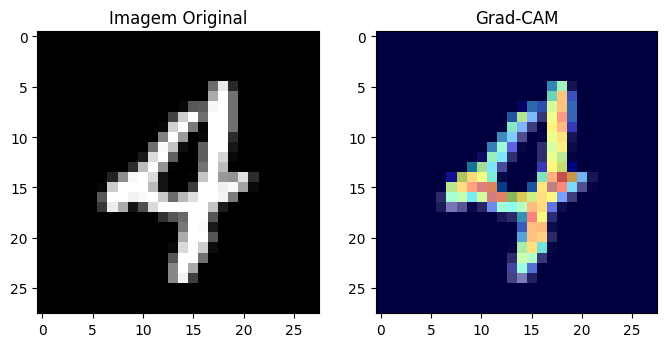

In [34]:
# Aplicar Grad-CAM na CNN Personalizada
grad_cam = GradCAM(cm_model, cm_model.conv1)

# Obter um lote de imagens
inputs, labels = next(iter(tests_manager))
inputs = inputs[0].unsqueeze(0)

# Gerar o mapa de ativação
cam_m = grad_cam.generate_cam(inputs)

# Visualizar o mapa de ativação
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(inputs.squeeze().cpu().numpy(), cmap='gray')
plt.title("Imagem Original")

plt.subplot(1,2,2)
plt.imshow(inputs.squeeze().cpu().numpy(), cmap='gray')
plt.imshow(cam_m, cmap='jet', alpha=0.5)    # Sobrepõe Grad-CAM
plt.title("Grad-CAM")
plt.show()


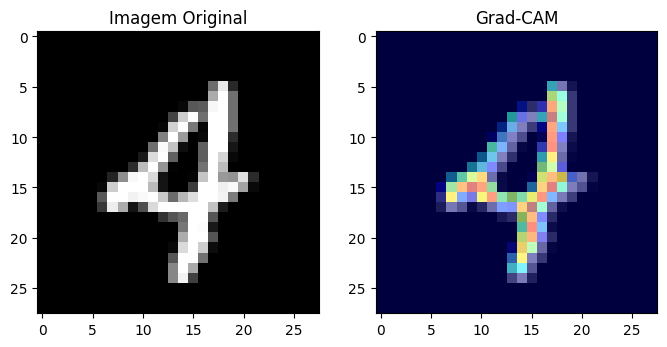

In [35]:
# Aplicar Grad-CAM na CNN Regularizada
grad_cam_r = GradCAM(cr_model, cr_model.conv1)

# Obter um lote de imagens
inputs, _ = next(iter(tests_manager))
inputs = inputs[0].unsqueeze(0)

# Gerar o mapa de ativação
cam_r = grad_cam_r.generate_cam(inputs)

# Visualizar o mapa de ativação
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(inputs.squeeze().cpu().numpy(), cmap='gray')
plt.title("Imagem Original")

plt.subplot(1,2,2)
plt.imshow(inputs.squeeze().cpu().numpy(), cmap='gray')
plt.imshow(cam_r, cmap='jet', alpha=0.5)    # Sobrepõe Grad-CAM
plt.title("Grad-CAM")
plt.show()

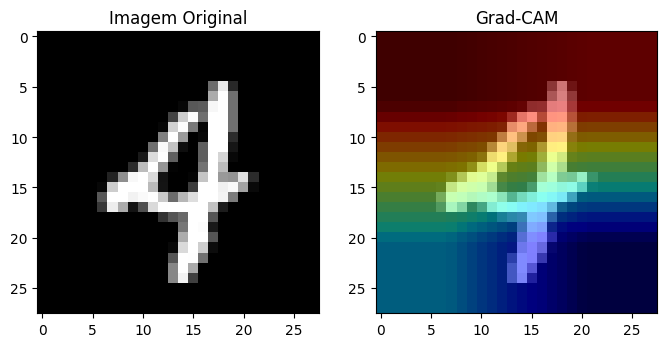

In [36]:
# Aplicar Grad-CAM no Modelo Pré-treinado
target_layer = p_model.layer4[-1].conv2 if hasattr(p_model, 'layer4') else p_model.conv2
grad_cam_p = GradCAM(p_model, target_layer)

# Obter a primeira imagem do conjunto de testes
inputs, _ = next(iter(tests_manager))
inputs = inputs[:1]

# Gerar o mapa de ativação Grad-CAM
cam_p = grad_cam_p.generate_cam(inputs)

# Visualizar o mapa de ativação
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(inputs.squeeze().cpu().numpy(), cmap='gray')
plt.title("Imagem Original")

plt.subplot(1,2,2)
plt.imshow(inputs.squeeze().cpu().numpy(), cmap='gray')
plt.imshow(cam_p, cmap='jet', alpha=0.5)    # Sobrepõe Grad-CAM
plt.title("Grad-CAM")
plt.show()

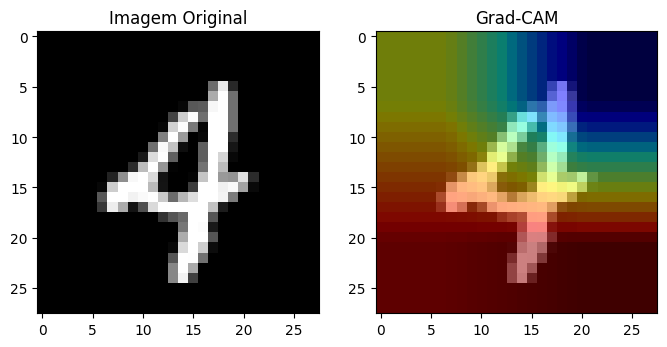

In [37]:
# Aplicar Grad-CAM no Modelo Pré-treinado Regularizado
target_layer = pr_model.layer4[-1].conv2 if hasattr(pr_model, 'layer4') else pr_model.conv2
grad_cam_pr = GradCAM(pr_model, target_layer)

# Obter a primeira imagem do conjunto de testes
inputs, _ = next(iter(tests_manager))
inputs = inputs[:1]

# Gerar o mapa de ativação Grad-CAM
cam_pr = grad_cam_pr.generate_cam(inputs)

# Visualizar o mapa de ativação
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(inputs.squeeze().cpu().numpy(), cmap='gray')
plt.title("Imagem Original")

plt.subplot(1,2,2)
plt.imshow(inputs.squeeze().cpu().numpy(), cmap='gray')
plt.imshow(cam_pr, cmap='jet', alpha=0.5)   # Sobrepõe Grad-CAM
plt.title("Grad-CAM")
plt.show()

# Conclusão
Os mapas de características nos permitem ver que durante o processo há partes que são consideradas mais relevantes para a decisão pelo modelo. Além disso, a complexidade do modelo é deixado clara ao se observar a grade.